In [158]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io as sio
import math
from scipy.signal import butter, lfilter, filtfilt, medfilt

matlab_file = './Sushant_CSI/1m/backward_converted/log_3.mat'

Text(0, 0.5, 'Amplitude')

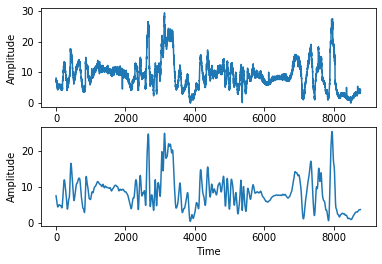

In [159]:
mat_contents = sio.loadmat(matlab_file)
antenna_1 = mat_contents['M']
subcarrier = 0   # Selected Subcarrier
fs = 1627        # Sampling Frequency
flt_ord = 12      # Filter order number

x_axis = []
y_axis = []
for i in range(0, len(antenna_1)):
    x_axis.append(i)
    y_axis.append(antenna_1[i][subcarrier])

# plt.specgram(y_axis, Fs=1000, cmap='viridis', NFFT=100, noverlap=99, scale_by_freq=True, xextent=(0,1.627))
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(y_axis)
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')

b, a = butter(flt_ord, 30/(fs/2), 'lowpass', analog=False)
output = filtfilt(b, a, y_axis)
ax2.plot(output)
ax2.set_xlabel('Time')
ax2.set_ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

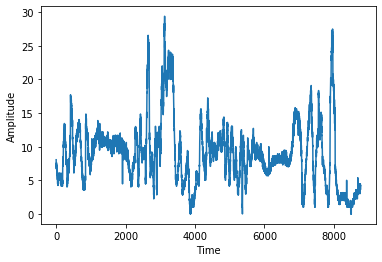

In [160]:
plt.plot(y_axis)
plt.xlabel('Time')
plt.ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

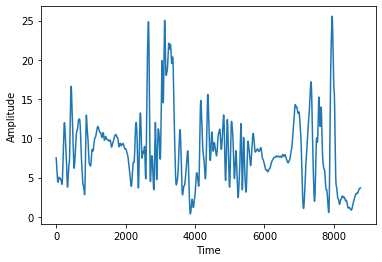

In [161]:
flt_ord = 12
b, a = butter(flt_ord, 30/(fs/2), 'lowpass', analog=False)
output = filtfilt(b, a, y_axis)
plt.plot(output)
plt.xlabel('Time')
plt.ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

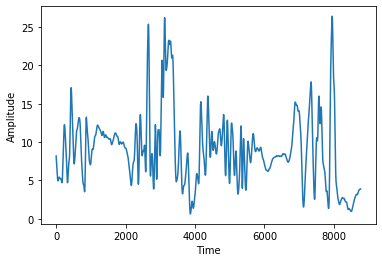

In [162]:
flt_ord = 5
b, a = butter(flt_ord, 30/(fs/2), 'lowpass', analog=False)
output = filtfilt(b, a, y_axis)
plt.plot(output)
plt.xlabel('Time')
plt.ylabel('Amplitude')

In [163]:
# -- SILENCE REMOVAL ---
import math

# 1. Separate the CSI data into a sequence of frames
num_packets = len(output)

# five_milisec is the number of data(frequency) in each frame.

data_per_frame = 50
total_num_frames = math.floor(num_packets/data_per_frame) 

print(total_num_frames)
frames = []

for frame in range(total_num_frames):
    cur_index = data_per_frame*frame
    seq = output[cur_index : cur_index+data_per_frame]
    frames.append(seq)
    

175


0
5666.5


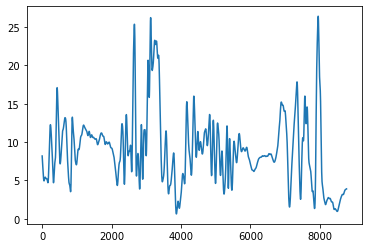

In [167]:


# Calculate energy for each frame
energy = []
for frame in frames:
    sq_sum = sum(map(lambda x: x*x, frame))
    e_frame = sq_sum/data_per_frame
    energy.append(e_frame)

# Apply median filter to energy values and take their log
filt_energy = medfilt(energy)
filt_energy = [math.log(e) for e in filt_energy]


# Get indices for which energies > mean energy
curr_index = 0
high_energy_indices = []
mean_energy = sum(filt_energy)/len(filt_energy)
for energy in filt_energy:
    if energy > mean_energy:
        high_energy_indices.append(curr_index)
    curr_index += 1;

# Split the high energy indices into contigious subsequences
curr_index = None
inside_arr = []
conti_arr = []
for index in high_energy_indices:
    if (curr_index is None):
        inside_arr.append(index)
    else:
        if (curr_index == index-1):
            inside_arr.append(index)
        else:
            conti_arr.append(inside_arr)
            inside_arr = []
            inside_arr.append(index)
    
    curr_index = index

if inside_arr:
    conti_arr.append(inside_arr)

# Select the longest contigious subsequence
s_mid = max(conti_arr, key=len)

# Get the h_mid which is the corresponding CSI data frames for s_mid
h_mid = []
for index in longest_list:
    h_mid.append(frames[index])
    
# Cacluate the midpoint of effective region
high_energy_csi = [item for sublist in h_mid for item in sublist]
avg_energy = sum(high_energy_csi)/len(high_energy_csi)

max_dev = 0
max_dev_index = 0
for index, energy in enumerate(high_energy_csi):
    deviation = abs(avg_energy - energy)
    if deviation > max_dev:
        max_dev = deviation
        max_dev_index = index
        
#print(max_dev)
#print(max_dev_index)
m = s_mid[0] * data_per_frame + max_dev_index

start_point = m - (num_packets)/2
start_point = max(start_point, 0)
end_point = m + (num_packets)/2
end_point = min(end_point, num_packets)

print(start_point)
print(end_point)

plt.plot(output)      
#plt.plot(filt_e_vals)
# print(len(frames[31]))


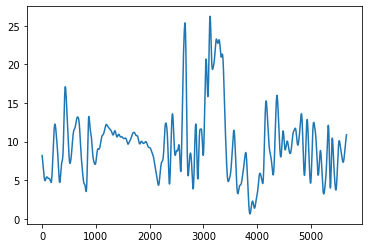

In [168]:
# Trimmed output is the final output.

trimmed_output = output[math.floor(start_point): math.floor(end_point)]
plt.plot(trimmed_output)